***
LIBRARIES: most required ones
***

In [1]:
!pip install tqdm torch torchsummary torchvision

     ---------------------------------------- 78.3/78.3 kB 4.5 MB/s eta 0:00:00
     ------------------------------------- 192.3/192.3 MB 16.4 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 40.4 MB/s eta 0:00:00
     ---------------------------------------- 5.7/5.7 MB 33.3 MB/s eta 0:00:00
     ------------------------------------- 536.2/536.2 kB 17.0 MB/s eta 0:00:00


In [16]:
from tqdm import tqdm # progress bar
import matplotlib.pyplot as plt # plot


import torch # pytorch
import torch.nn as nn # neural network
import torch.optim as optim # optimizer
from torchsummary import summary # model summary (architecture)
from torch.utils.data import DataLoader, random_split # dataloader, dataset split
from torchvision import transforms,datasets, utils # image processing, datasets
import torchvision.models as models # pretrained models
import numpy as np # numpy

DATA_PATH = './dataset'

***
DATA LOADING
***

In [7]:
#Transformation for image
transform_ori = transforms.Compose([transforms.RandomResizedCrop(128),   #create 64x64 image
                                    transforms.RandomHorizontalFlip(),    #flipping the image horizontally
                                    transforms.ToTensor(),                 #convert the image to a Tensor
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  #normalize the image
                                    
dataset = datasets.ImageFolder(root = DATA_PATH, transform=transform_ori)
data_size = len(dataset)

In [8]:
test_size = int(data_size * 0.20)
train_size = data_size - test_size
generator = torch.Generator().manual_seed(42)
training, testing = random_split(dataset, [train_size, test_size], generator=generator)

In [9]:
batch_size = 32

# Training DataLoader
train_loader = DataLoader(
    dataset=training,
    batch_size=batch_size,
    shuffle=True
)

# Testing DataLoader
test_loader = DataLoader(
    dataset=testing,
    batch_size=batch_size,
    shuffle=False
)


In [11]:
classes = ('cloudy','foggy','rainy','shine','sunrise')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


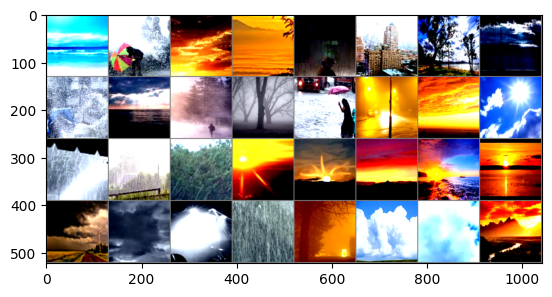

shine rainy sunrise sunrise rainy rainy shine cloudy rainy cloudy foggy foggy rainy foggy sunrise shine rainy rainy rainy sunrise sunrise sunrise sunrise sunrise cloudy cloudy foggy rainy foggy cloudy cloudy sunrise


In [17]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))

***
ARCHITECTURE DEFINING
***

In [32]:
# Create a neural net class
class Net(nn.Module):
    
    
    # Defining the Constructor
    def __init__(self, num_classes=5):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lastcnn = nn.Linear(in_features=64 * 64 * 64, out_features=5)   
        self.relu=nn.ReLU()     

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x) 
        x = x.view(x.size(0), -1)    
        x = self.relu(self.lastcnn(x))  # Move ReLU after the fully connected layer
        return torch.log_softmax(x, dim=1)
    
   
    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

model = Net(num_classes=5).to(device)

In [34]:
class ImprovedNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ImprovedNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 32 * 32, 256)  # Adjust the input size based on your image dimensions
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)

# Create an instance of the improved model
improved_model = ImprovedNet(num_classes=5).to(device)
improved_model

ImprovedNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
  (relu): ReLU()
)

In [21]:
model

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lastcnn): Linear(in_features=262144, out_features=5, bias=True)
  (relu): ReLU()
)

***
OBJECTS: CRITERION, OPTIMIZER, SCHEDULER(maybe)
***

In [42]:
model = ImprovedNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

***
TRAINING AND VALIDATION: Validation not neccessary but recommended
***

In [41]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0.0
    total_batches = len(train_loader)

    print("Epoch:", epoch)

    # Process the images in batches
    for i, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = criterion(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} / {}: Loss: {:.6f}'.format(i + 1, total_batches, loss.item()))
    
    # Calculate average loss for the epoch
    avg_loss = train_loss / total_batches
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    
    return avg_loss


In [43]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = criterion(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [37]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += criterion(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [45]:
epoch_nums = []
training_loss = []
validation_loss = []

epochs = 5
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
	Training batch 1 Loss: 1.631375
	Training batch 2 Loss: 123.207695
	Training batch 3 Loss: 754.389282
	Training batch 4 Loss: 42.184181
	Training batch 5 Loss: 231.652557
	Training batch 6 Loss: 215.144012
	Training batch 7 Loss: 265.724091
	Training batch 8 Loss: 131.321198
	Training batch 9 Loss: 239.241470
	Training batch 10 Loss: 66.402390
	Training batch 11 Loss: 144.338135
	Training batch 12 Loss: 347.038788
	Training batch 13 Loss: 189.866562
	Training batch 14 Loss: 214.657486
	Training batch 15 Loss: 44.010628
	Training batch 16 Loss: 52.160431
	Training batch 17 Loss: 41.580662
	Training batch 18 Loss: 152.878677
	Training batch 19 Loss: 112.776627
	Training batch 20 Loss: 66.211548
	Training batch 21 Loss: 113.210114
	Training batch 22 Loss: 80.962234
	Training batch 23 Loss: 91.390717
	Training batch 24 Loss: 38.090931
	Training batch 25 Loss: 40.636250
	Training batch 26 Loss: 64.899048
	Training batch 27 Loss: 37.957924
	Training batch 28 Loss: 3

***
PLOTTING: Loss & Accuracy
***

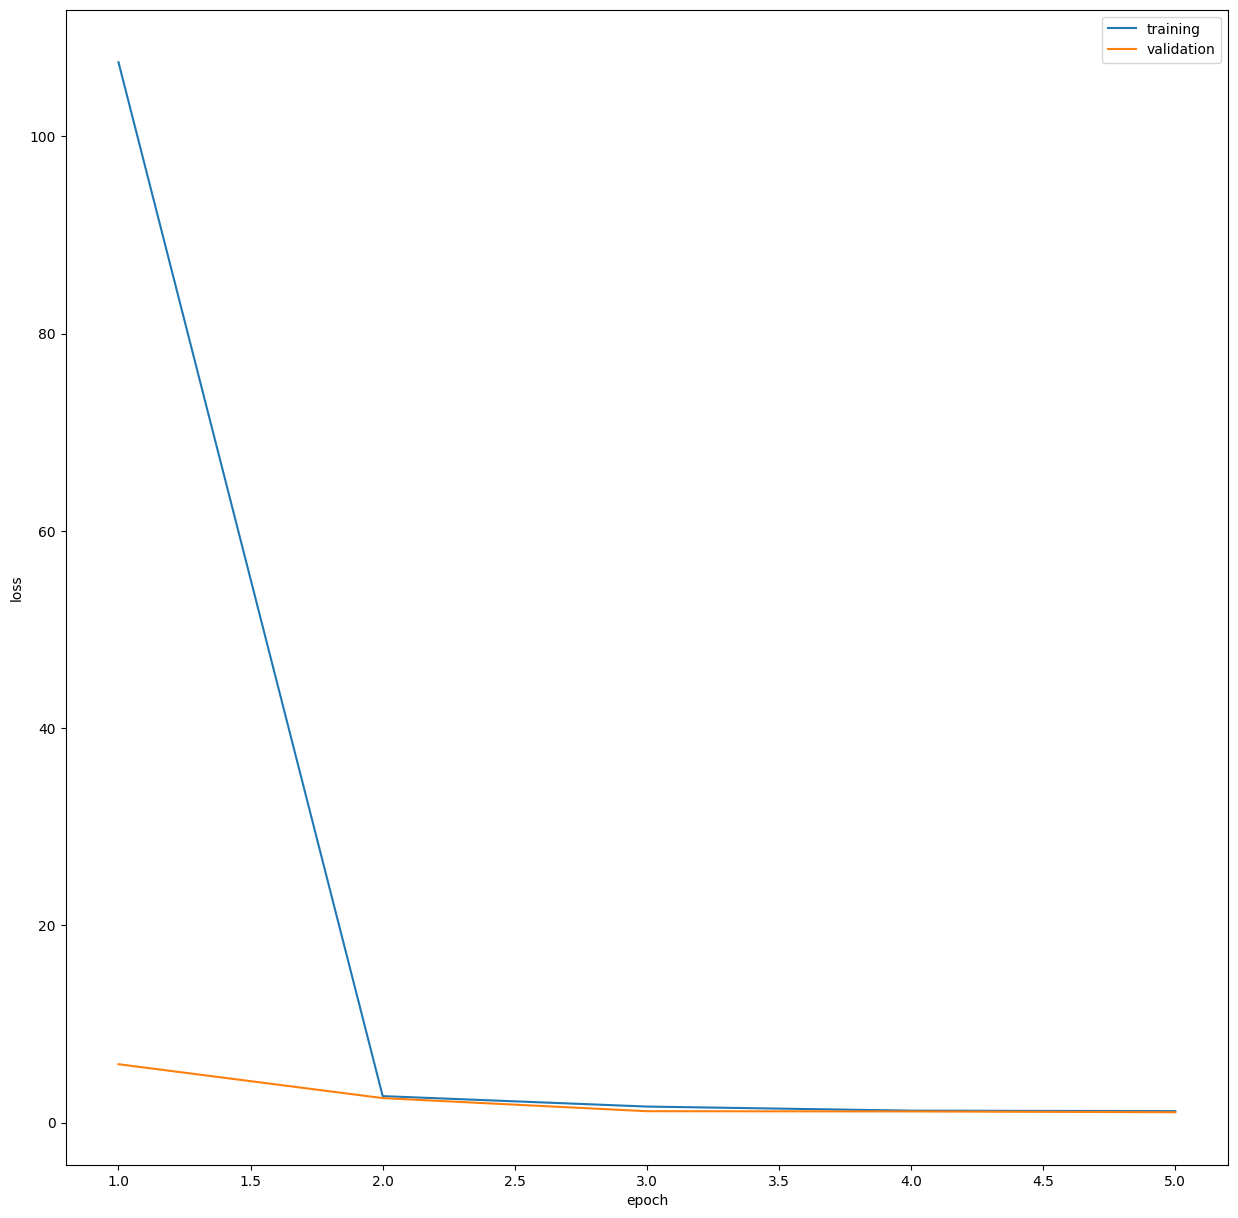

In [46]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

***
SAVING
***

In [ ]:
width,height = 128,128
x = torch.Tensor(1, 3, width, height)
with torch.no_grad():
    traced_cell = torch.jit.trace(model, (x))
model_name = "./models/C_team2.pt" # CHANGE THIS TO YOUR OWN PATH (most improtatnt step)
torch.jit.save(traced_cell, model_name)


# torch.save () this is not allowed because it requires class definition before loading for the 
# model evaluation